### Импортируем библиотеки

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
from matplotlib.cm import get_cmap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Импортируем трейн и тест

In [115]:
train = pd.read_csv("./titanic/train.csv")

In [116]:
test = pd.read_csv("./titanic/test.csv")

## А что у нас в данных?

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [118]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [119]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [120]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


train: 
- так у нас полно пропусков в Age и Embarked, 
- посмотрим по корреляции нужно ли что то делать с другими колонками
- в принципе, можем добвить еще и титул из предыдущего урока, может быть полезно.


test:
- заполним Age, важно что *ТОЛЬКО* данными из трейна а то получится у нас утечечка данных

#### Корреляция

Изначально вот так:

In [121]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


добавим колонки на выброс(с Cabin я не согласен)

#### Добавляем данные и заполняем пропуски

In [122]:
def add_title(df):
    mapping = {'Don': 'RoyaltyM', 'Mme': 'Miss', 'Ms': 'Miss',
    'Major': 'Officer', 'Lady': 'RoyaltyF', 'Sir': 'RoyaltyM', 
    'Mlle': 'Miss', 'Col': 'Officer', 'Capt': 'Officer',
    'Countess': 'RoyaltyF', 'Jonkheer': 'RoyaltyM'}
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.')
    df.replace({'Title': mapping}, inplace=True)
    return df

In [123]:
def fill_in_age(df):
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
    return df

In [124]:
def drop_unneeded(df):
    cols_to_drop = ['PassengerId','Name','Ticket','Cabin']
    return df.drop(cols_to_drop,axis=1)

In [125]:
def clean_embarked(df):
    max_embarked = df['Embarked'].value_counts().idxmax()
    return df.fillna(max_embarked)

In [126]:
result = pd.DataFrame(test['PassengerId'])

In [127]:
train = train.pipe(add_title).pipe(fill_in_age).pipe(drop_unneeded).pipe(clean_embarked)

In [128]:
train = train.dropna()

In [129]:
test = test.pipe(add_title).pipe(fill_in_age).pipe(drop_unneeded)

In [130]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,34.5,0,0,7.8292,Q,Mr
1,3,female,47.0,1,0,7.0000,S,Mrs
2,2,male,62.0,0,0,9.6875,Q,Mr
3,3,male,27.0,0,0,8.6625,S,Mr
4,3,female,22.0,1,1,12.2875,S,Mrs
...,...,...,...,...,...,...,...,...
413,3,male,28.5,0,0,8.0500,S,Mr
414,1,female,39.0,0,0,108.9000,C,Dona
415,3,male,38.5,0,0,7.2500,S,Mr
416,3,male,28.5,0,0,8.0500,S,Mr


In [131]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.078177,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.353278,0.083081,0.018443,-0.549500
Age,-0.078177,-0.353278,1.000000,-0.264999,-0.188285,0.097675
SibSp,-0.035322,0.083081,-0.264999,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.188285,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.097675,0.159651,0.216225,1.000000


In [132]:
test.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.470427,0.001087,0.018721,-0.577147
Age,-0.470427,1.000000,-0.086816,-0.028701,0.340561
SibSp,0.001087,-0.086816,1.000000,0.306895,0.171539
Parch,0.018721,-0.028701,0.306895,1.000000,0.230046
Fare,-0.577147,0.340561,0.171539,0.230046,1.000000


In [133]:
cats = ['Sex','Embarked','Title']

/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[c],color='green')
/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[c],color='r

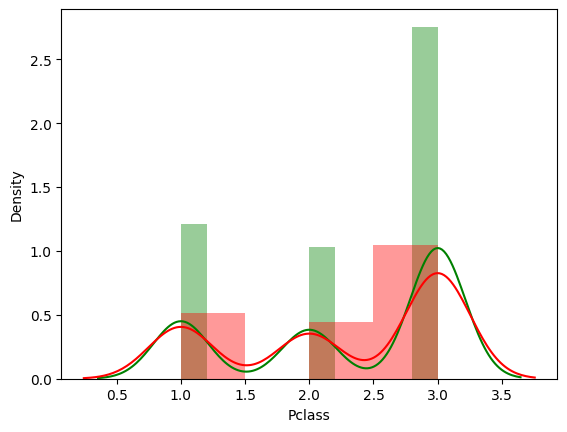

/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[c],color='green')
/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[c],color='r

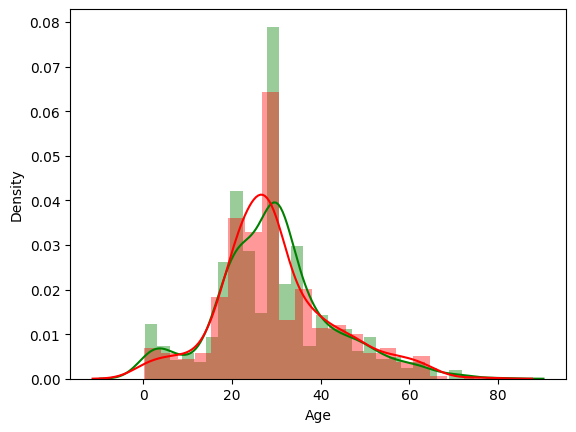

/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[c],color='green')
/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[c],color='r

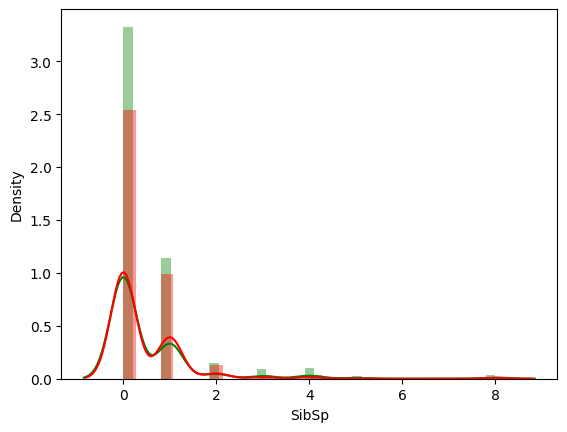

/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[c],color='green')
/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[c],color='r

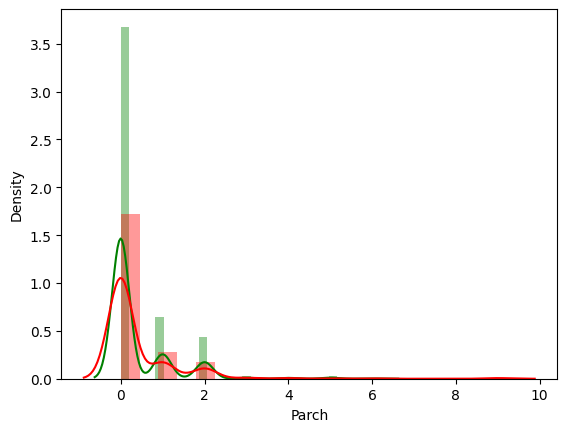

/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[c],color='green')
/var/folders/4_/j00hlvmx41x_zq1xp7jhyw500000gn/T/ipykernel_18281/4202675947.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[c],color='r

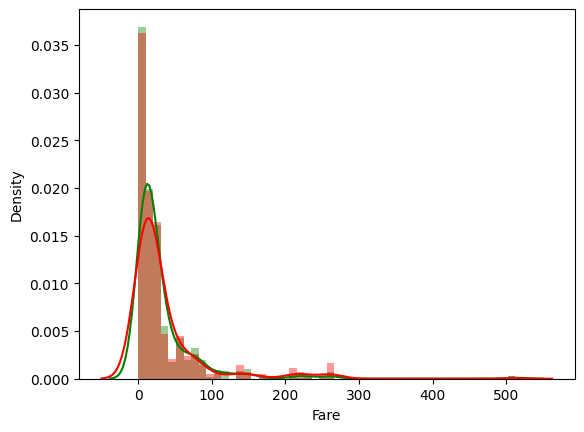

In [134]:
for c in test.drop(cats,axis=1).columns:
    sns.distplot(train[c],color='green')
    sns.distplot(test[c],color='red')
    plt.show()

Ага все нормально классы не уехали

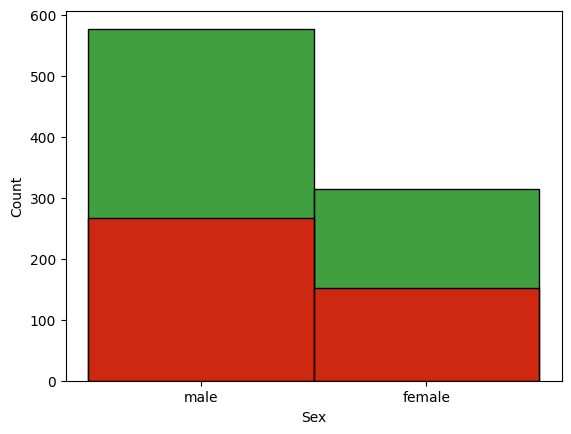

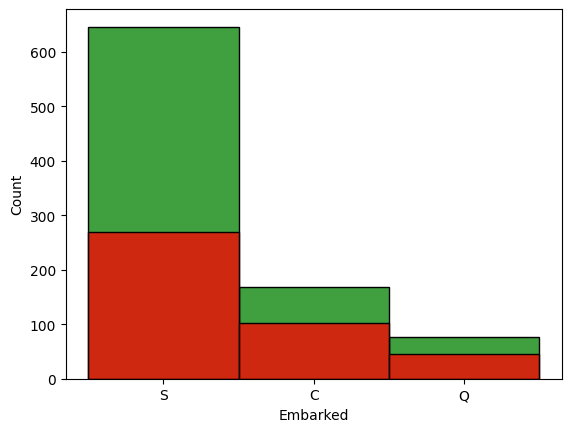

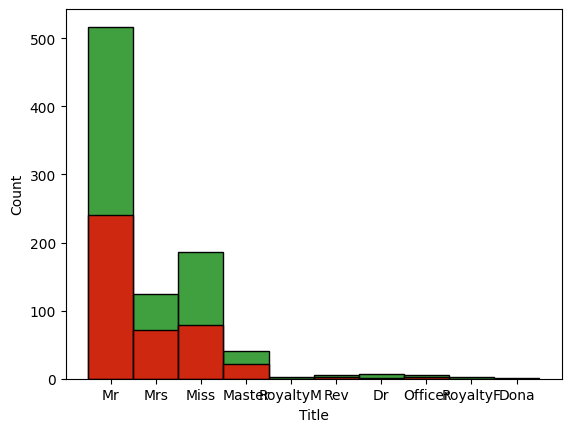

In [135]:
for c in train[cats].columns:
    p = sns.histplot(train[c],color='g')
    sns.histplot(test[c],color='r')
    plt.show()

Dona - есть тока в тесте и это ломает энкодеры

И тут хорошо

### Кодирование признаков

#### попробуем энкодер - LabelEncoder

In [138]:
target_train = train['Survived']
#target_test = test['Survived']
train = train.drop('Survived',axis=1)

In [109]:
#le = LabelEncoder()

In [139]:
ohe = OneHotEncoder(drop='first',handle_unknown='ignore')

In [141]:
ohe.fit(train)

OneHotEncoder(drop='first', handle_unknown='ignore')

In [144]:
ohe_train = ohe.transform(train)

In [143]:
ohe_test = ohe.transform(test)

/Users/inenashev/Documents/Projects/tchk/lt/result_comparision/tchk_ds/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2, 4, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [145]:
model_rf = RandomForestClassifier(n_estimators=100)
model_kn = KNeighborsClassifier(n_neighbors=20)

In [147]:
scores = cross_val_score(model_rf, ohe_train, target_train, cv=5)
print(scores)
print(scores.mean())

scores = cross_val_score(model_kn, ohe_train, target_train, cv=5)
print(scores)
print(scores.mean())

[0.84357542 0.79213483 0.83146067 0.76966292 0.83146067]
0.8136589040236017
[0.82681564 0.82022472 0.83146067 0.78089888 0.8258427 ]
0.817048521750047


In [148]:
model_rf = model_rf.fit(ohe_train, target_train)
predictions = model_rf.predict(ohe_test)